In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/PLDD

Mounted at /content/drive
/content/drive/MyDrive/PLDD


In [ ]:
import numpy as np
import pickle
import cv2
import os
from PIL import Image
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD, Adagrad, Adadelta,RMSprop,Adamax,Nadam
from keras.preprocessing import image
from tensorflow.keras.utils import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 50
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = 'custom_dataset/SRGAN_input/'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
            print(image_dir)
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
image_folder = 'custom_dataset/SRGAN_input/PlantVillage'
image_list = []
label_list = []
max_images_per_folder = 225

for folder in os.listdir(image_folder):
    folder_count = 0
    for image_file in os.listdir(os.path.join(image_folder, folder)):
        try:
            if folder_count >= max_images_per_folder:
                break
            image = Image.open(os.path.join(image_folder, folder, image_file))
            image_array = np.asarray(image)
            image_list.append(image_array)
            label_list.append(folder)
            folder_count += 1
        except:
            print(f"Deleted file: {os.path.join(image_folder, folder, image_file)}")


In [ ]:
image_size = len(image_list)
image_size

3302

In [ ]:
lable_size = len(label_list)
lable_size

3302

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('SRCNN_label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [ ]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0

In [ ]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model.add(Conv2D(16, (3, 3), padding="same", input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(32, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 activation (Activation)     (None, 256, 256, 16)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 32)        4

In [ ]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS, amsgrad=True)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


In [ ]:
history = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/50
82/82 [==============================] - 62s 632ms/step - loss: 1.6393 - accuracy: 0.4937 - val_loss: 6.2371 - val_accuracy: 0.0681
Epoch 2/50
82/82 [==============================] - 41s 496ms/step - loss: 1.0800 - accuracy: 0.6524 - val_loss: 10.5597 - val_accuracy: 0.0681
Epoch 3/50
82/82 [==============================] - 41s 495ms/step - loss: 0.8990 - accuracy: 0.7018 - val_loss: 8.4346 - val_accuracy: 0.1331
Epoch 4/50
82/82 [==============================] - 41s 496ms/step - loss: 1.0304 - accuracy: 0.6738 - val_loss: 6.9805 - val_accuracy: 0.2012
Epoch 5/50
82/82 [==============================] - 40s 491ms/step - loss: 0.9039 - accuracy: 0.7072 - val_loss: 6.1654 - val_accuracy: 0.1967
Epoch 6/50
82/82 [==============================] - 40s 482ms/step - loss: 0.8188 - accuracy: 0.7374 - val_loss: 4.2939 - val_accuracy: 0.2557
Epoch 7/50
82/82 [==============================] - 40s 490ms/step - loss: 0.6546 - accuracy: 0.7831 - val_loss: 1.1422 - val_accuracy: 0.646

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
21/21 [==============================] - 1s 25ms/step - loss: 0.3744 - accuracy: 0.8865
Test Accuracy: 88.65355253219604


In [ ]:
model.save('SRCNN_model.h5')

In [ ]:
print("[INFO] Saving model...")
pickle.dump(model,open('SRCNN_model.pkl', 'wb'))

[INFO] Saving model...


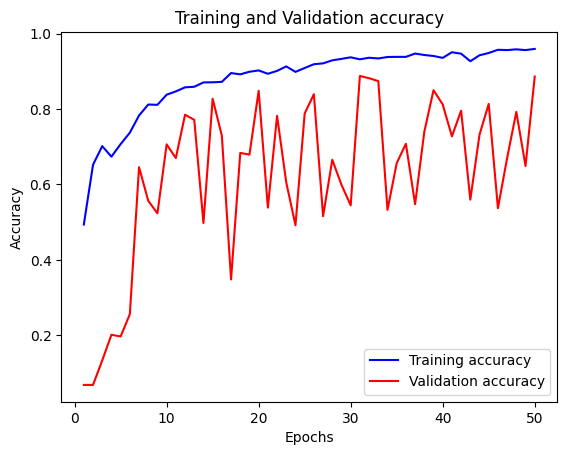

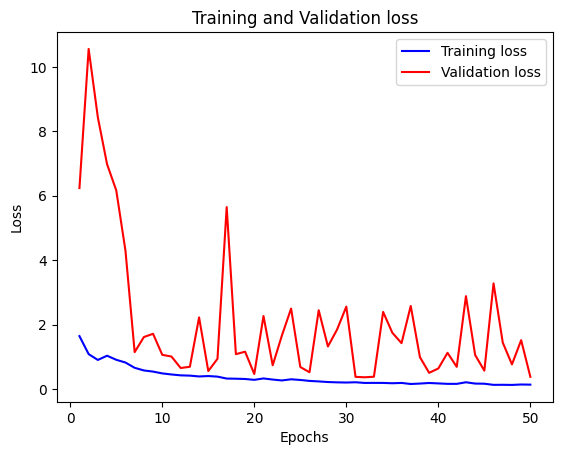

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
#plt.savefig("TrainingAValidationAccuracy.png")

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation loss')
plt.legend()
#plt.savefig("TrainingAValidationLoss.png")
plt.show()

In [ ]:
from PIL import Image
image_dir="custom_dataset/input_64/PlantVillage/Tomato__Tomato_mosaic_virus/0a7cc59f-b2b0-4201-9c4a-d91eca5c03a3___PSU_CG 2230.JPG"
im1 = Image.open(image_dir)

im=convert_image_to_array(image_dir)
np_image_li = np.array(im, dtype=np.float16) / 225.0
npp_image = np.expand_dims(np_image_li, axis=0)

In [ ]:
result=model.predict(npp_image)
print(result)

1/1 [==============================] - 1s 552ms/step
[[2.8308416e-06 1.0181034e-06 5.6689470e-10 9.5944215e-06 2.6320387e-03
  1.2327202e-07 4.8555313e-07 9.3133652e-09 3.8202296e-07 9.4963324e-01
  2.7277759e-08 1.5153668e-07 6.1944519e-08 4.7720127e-02 1.8975088e-10]]


In [ ]:
itemindex = np.where(result==np.max(result))
print("probability:"+str(np.max(result))+"\n"+label_binarizer.classes_[itemindex[1][0]])

probability:0.94963324
Tomato_Septoria_leaf_spot
